In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.python.client import device_lib
import keras.backend.common
from keras.backend.common import image_dim_ordering
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras import backend, regularizers, optimizers, callbacks, Sequential
from keras.utils import np_utils
from keras.callbacks import TensorBoard,EarlyStopping

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score ,multilabel_confusion_matrix

import itertools
import gc

Using TensorFlow backend.


In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
tf.device("/GPU:0")

In [4]:

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4057614150782782371
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4986830848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3917202989965599513
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [5]:
backend.clear_session()
gc.collect()

49

In [6]:
PATH = os.getcwd()

print(PATH)
data_path = '../Object Detection/data/'

data_dir_list = os.listdir(data_path)

C:\Users\micka\Documents\dev\Object_recognition


In [7]:
print(data_dir_list)

['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']


In [8]:
img_rows = 128
img_cols = 128
num_channel = 1

## Define number of classes

num_classes = 7
img_data_list = []

for dataset in data_dir_list:
    
    img_list = os.listdir(data_path+'/'+dataset)
    print('Loading images of dataset of {}'.format(dataset))
    
    for img in img_list:
        #read image
        input_img = cv2.imread(data_path +'/'+ dataset+'/'+img)
        #convert image to grayscale
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        # reshape image
        resized_img = cv2.resize(input_img, (128,128))
        
        img_data_list.append(resized_img)

Loading images of dataset of bike
Loading images of dataset of cars
Loading images of dataset of cats
Loading images of dataset of dogs
Loading images of dataset of flowers
Loading images of dataset of horses
Loading images of dataset of human


In [9]:
img_data = np.array(img_data_list)

img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

(1803, 128, 128)


In [10]:
type(num_channel)

int

In [11]:
if num_channel==1:
    if image_dim_ordering()=='th': ## if using theano backend shape
        img_data= np.expand_dims(img_data, axis=1) 
        print (img_data.shape)
    else: ## if using tensorflow backend shape
        img_data= np.expand_dims(img_data, axis=4) 
        print(img_data.shape)

else:
    if image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)

(1803, 128, 128, 1)


In [12]:
num_classes = 7
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')
labels[0:365]=0
labels[365:567]=1
labels[567:987]=2
labels[987:1189]=3
labels[1189:1399]=4
labels[1399:1601]=5
labels[1601:1803]=6
names = ['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']

In [13]:
Y = np_utils.to_categorical(labels, num_classes)

In [14]:
x,y = shuffle(img_data, Y, random_state = 1234)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 2)

In [15]:
print("X_train_shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train_shape : (1442, 128, 128, 1)
X_test shape : (361, 128, 128, 1)


<function matplotlib.pyplot.show(*args, **kw)>

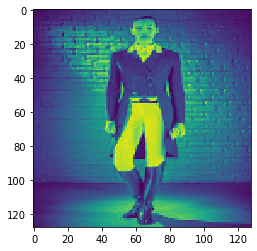

In [16]:
image = X_train[1203,:].reshape((128,128))
plt.imshow(image)
plt.show

In [17]:
input_dim = X_train[0].shape

In [18]:
input_dim

(128, 128, 1)

In [19]:
acc_per_fold = []
loss_per_fold = []
roc_per_fold = []
np.random.seed(2)
kfold = KFold(n_splits = 5, shuffle = True)

fold_no = 1


inputs = np.concatenate((X_train, X_test), axis = 0)
targets = np.concatenate((y_train, y_test), axis = 0)
with tf.device("/GPU:0"):

    for train, test in kfold.split(inputs, targets):
        cnn_model = Sequential()

        cnn_model.add(Convolution2D(128,3,3, border_mode = 'same', activation = 'relu', input_shape = input_dim, kernel_regularizer = regularizers.l2(1e-6)))
        cnn_model.add(Convolution2D(128,3,3, activation = 'relu'))
        cnn_model.add(MaxPooling2D(pool_size = (2,2)))
        cnn_model.add(Dropout(0.5))

        cnn_model.add(Flatten())
        cnn_model.add(Dense(128, activation = 'relu', activity_regularizer = regularizers.l2('1e-4')))
        cnn_model.add(Dropout(0.5))

        cnn_model.add(Dense(128, activation = 'relu', activity_regularizer = regularizers.l2('1e-4')))
        cnn_model.add(Dropout(0.5))
        cnn_model.add(Dense(num_classes, activation = 'softmax'))

        #callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 15)
        opt = optimizers.Adam(learning_rate = 5e-4)

        cnn_model.compile(loss = 'categorical_crossentropy', optimizer= opt,#'adadelta',
                         metrics = ["accuracy"])

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        history = cnn_model.fit(inputs[train], 
                            targets[train],
                            epochs = 25,
                            batch_size = 16,
                            #callbacks = callback,
                            verbose = True)
        loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose = True)

        y_pred = cnn_model.predict(X_test)
        y_pred = y_pred > 0.5

        acc_per_fold.append(accuracy)
        loss_per_fold.append(loss)
        roc_per_fold.append(roc_auc_score(y_test, y_pred))

        fold_no +=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
1442/1442 [==============================] - 12s 8ms/step - loss: 1.9926 - accuracy: 0.2094
Epoch 2/25
1442/1442 [==============================] - 8s 6ms/step - loss: 1.8526 - accuracy: 0.2691
Epoch 3/25
1442/1442 [==============================] - 8s 6ms/step - loss: 1.6759 - accuracy: 0.3752: 1s - l
Epoch 4/25
1442/1442 [==============================] - 8s 6ms/step - loss: 1.4610 - accuracy: 0.4757
Epoch 5/25
1442/1442 [==============================] - 8s 6ms/step - loss: 1.2578 - accuracy: 0.5680: 0s - loss: 1.2610 - accuracy
Epoch 6/25
1442/1442 [==============================] - 8s 6ms/step - loss: 1.0361 - accuracy: 0.6567
Epoch 7/25
1442/1442 [==============================] - 8s 6ms/step - loss: 0.8606 - accuracy: 0.7441
Epoch 8/25
1442/1442 [==============================] - 8s 6ms/step - loss: 0.7551 - accuracy: 0.7850
Epoch 9/25
1442/1442 [==========================

361/361 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/25
1443/1443 [==============================] - 9s 6ms/step - loss: 1.9438 - accuracy: 0.2252
Epoch 2/25
1443/1443 [==============================] - 8s 6ms/step - loss: 1.7770 - accuracy: 0.3001
Epoch 3/25
1443/1443 [==============================] - 8s 6ms/step - loss: 1.6372 - accuracy: 0.3909
Epoch 4/25
1443/1443 [==============================] - 8s 6ms/step - loss: 1.4341 - accuracy: 0.4934
Epoch 5/25
1443/1443 [==============================] - 8s 6ms/step - loss: 1.2296 - accuracy: 0.5683
Epoch 6/25
1443/1443 [==============================] - 8s 6ms/step - loss: 1.0589 - accuracy: 0.6466
Epoch 7/25
1443/1443 [==============================] - 8s 6ms/step - loss: 0.8758 - accuracy: 0.7387
Epoch 8/25
1443/1443 [==============================] - 8s 6ms/step - loss: 0.7595 - accuracy: 0.7775
Epoch 9/25
1443/1443 [==========

In [20]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Roc_Auc_Score: {np.mean(roc_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.31683685529430156 - Accuracy: 0.9418282508850098%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.34654485543679003 - Accuracy: 0.9168975353240967%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.3807559942934982 - Accuracy: 0.886426568031311%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.3268297109494909 - Accuracy: 0.9168975353240967%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3134120697790236 - Accuracy: 0.9224376678466797%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.9168975114822387 (+- 0.017780402101764212)
> Loss: 0.33687589715062083
> Roc_Auc_Score: 0

In [54]:
test = cnn_model.predict(X_test)

test_pooled = test > 0.5

multilabel_confusion_matrix(y_test, test_pooled)

array([[[289,   0],
        [  8,  64]],

       [[323,   2],
        [  7,  29]],

       [[254,   8],
        [  8,  91]],

       [[320,   1],
        [  7,  33]],

       [[327,   1],
        [  1,  32]],

       [[320,   1],
        [  3,  37]],

       [[319,   1],
        [  3,  38]]], dtype=int64)

In [59]:
with tf.device("/GPU:0"):
    num_epoch = 3


    history2 = cnn_model.fit(X_train, y_train, batch_size=16, 
                           epochs = num_epoch, verbose = True
                           )

    #print(history.history)
    train_loss = history2.history['loss']
    val_loss = history2.history['val_loss']
    train_acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']


    xc = range(num_epoch)

Epoch 1/3
1442/1442 [==============================] - 8s 5ms/step - loss: 0.2470 - accuracy: 0.9438
Epoch 2/3
1442/1442 [==============================] - 8s 5ms/step - loss: 0.2002 - accuracy: 0.9626
Epoch 3/3
1442/1442 [==============================] - 8s 5ms/step - loss: 0.1978 - accuracy: 0.9646


KeyError: 'val_loss'

In [57]:
train_loss

[0.5199068279035296, 0.3601537873444048, 0.28396531796385116]

In [58]:
val_loss

[0.30459716792251923, 0.28291860610824543, 0.2594029258658021]

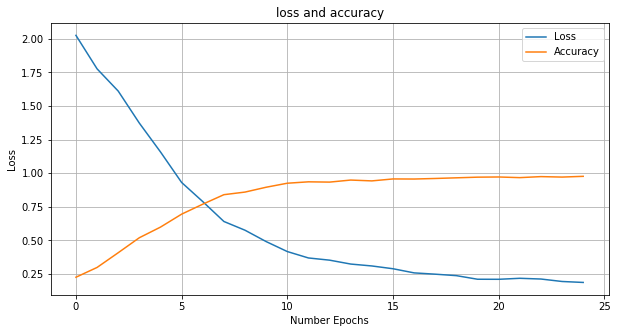

In [37]:
xc = range(25)
plt.figure(1, figsize=(10,5))
plt.plot(xc, history.history['loss'])
plt.plot(xc, history.history['accuracy'])
plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.title('loss and accuracy')
plt.grid(True)

plt.legend(['Loss', 'Accuracy'])
plt.style.use(['classic'])

In [24]:
plt.figure(2,figsize=(10,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['Train Accuracy','Validation Accuracy'],loc=4)
plt.style.use(['classic'])

NameError: name 'xc' is not defined

<Figure size 720x360 with 0 Axes>

In [38]:
score = cnn_model.evaluate(X_test, y_test, verbose=True)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

361/361 [==============================] - 0s 1ms/step
Test Loss: 0.3134120658163879
Test Accuracy: 0.9224376678466797


In [50]:
test_image = X_test[0:1]
print (test_image.shape)
print(cnn_model.predict(test_image))
print(cnn_model.predict_classes(test_image))
print(y_test[0:1])

(1, 128, 128, 1)
[[1.3764342e-04 2.2618654e-04 9.9887556e-01 3.6227607e-04 1.0426656e-04
  4.3883443e-05 2.5028619e-04]]
[2]
[[0. 0. 1. 0. 0. 0. 0.]]


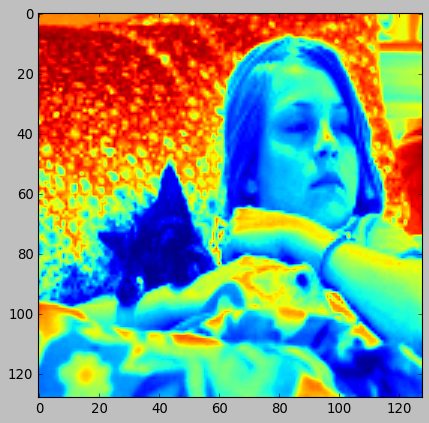

In [51]:
image = test_image.reshape((128,128))
plt.imshow(image)
plt.show()

In [49]:
names

['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']